In [2]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import sys
sys.path.append('../../../')
import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *


# Load SMOTE binding data 

In [3]:
split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/'
train_x_df = pd.read_csv(split_path+"/bind/bind_train_x_Morgan2SMOTE.csv")

train_y_df= pd.read_csv(split_path+"/bind/bind_train_y_Morgan2SMOTE.csv")
test_x_df= pd.read_csv(split_path+"/bind/bind_test_x_Morgan2SMOTE.csv")
test_y_df= pd.read_csv(split_path+"/bind/bind_test_y_Morgan2SMOTE.csv")
train_x = train_x_df.values
train_y = train_y_df.values.reshape(-1)  
test_x = test_x_df.values
test_y = test_y_df.values.reshape(-1)  

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2159, 2048), (2159,), (282, 2048), (282,))

TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, specificity: 1.000
TEST: accuracy: 0.940, precision: 0.273, recall: 0.250, specificity: 0.970


<Figure size 600x400 with 0 Axes>

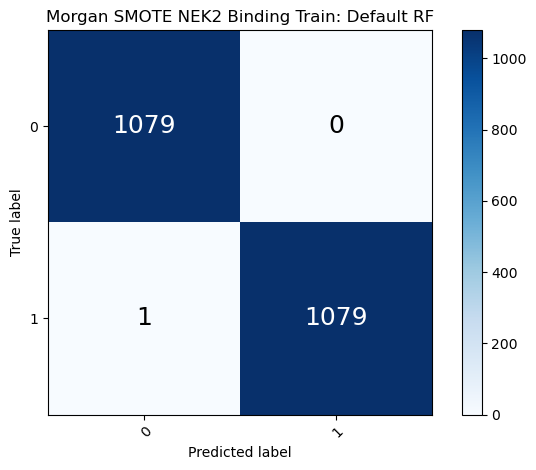

<Figure size 600x400 with 0 Axes>

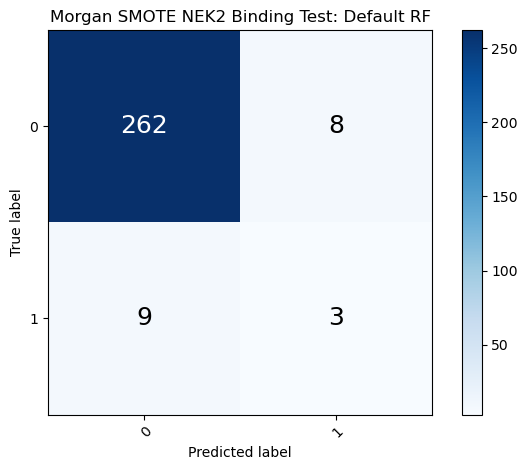

In [4]:
rf_basic100est = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {})
plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='Morgan SMOTE NEK2 Binding Train: Default RF')
plot_confusion_matrix(test_y, rf_basic100est['test_pred'], ['0','1'], title='Morgan SMOTE NEK2 Binding Test: Default RF')

In [9]:
for param,value in rf_basic100est['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [15]:
fn_basic  = (test_y == 1) & (rf_basic100est['test_pred'] == 0)
results_fn  = test_x[fn_basic]
fn_indicies  = np.where(fn_basic)
fn_indicies

(array([271, 272, 273, 274, 275, 277, 279, 280, 281, 282]),)

In [7]:
max_depths = [20,50,100]
n_estimators = [100,200,500]
max_features = [50,100,300]

In [11]:

# rf_plots(train_x, train_y, test_x, test_y, max_depths, n_estimators, max_features, 'basic RF', parameters={}, dataset_type='binding')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [5]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [6]:
save_file = 'atom_nek2bindMorgan2SMOTE_rf_basic_grid.pkl'
# rf_basicbest = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,2)
# with open(save_file, 'wb') as f:
#     pickle.dump(rf_basicbest['best_model'], f)

TRAIN: accuracy: 0.989, precision: 0.996, recall: 0.982,  specificity: 0.996
TEST: accuracy: 0.957, precision: 0.500, recall: 0.250, specificity: 0.989
bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: entropy
max_depth: 20
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 4
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

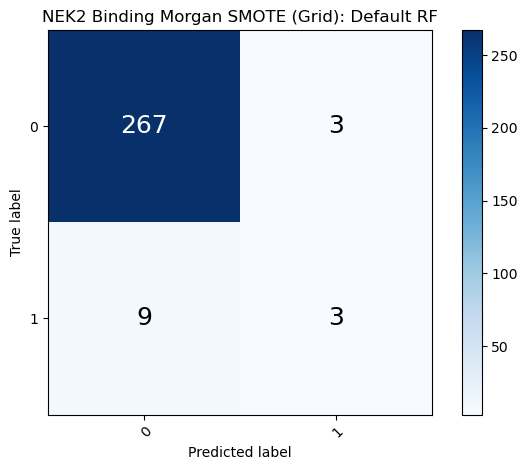

In [7]:
with open('../saved_models/atom_nek2bindMorgan2SMOTE_rf_basic_grid.pkl', 'rb') as f: 
    rf_basic_best = pickle.load(f) 

results_basic = rf_results2(rf_basic_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y,results_basic['test_pred'], ['0','1'], title='NEK2 Binding Morgan SMOTE (Grid): Default RF')
for param,value in rf_basic_best.get_params().items(): 
    print(f'{param}: {value}')


# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, specificity: 1.000
TEST: accuracy: 0.933, precision: 0.231, recall: 0.250, specificity: 0.963


<Figure size 600x400 with 0 Axes>

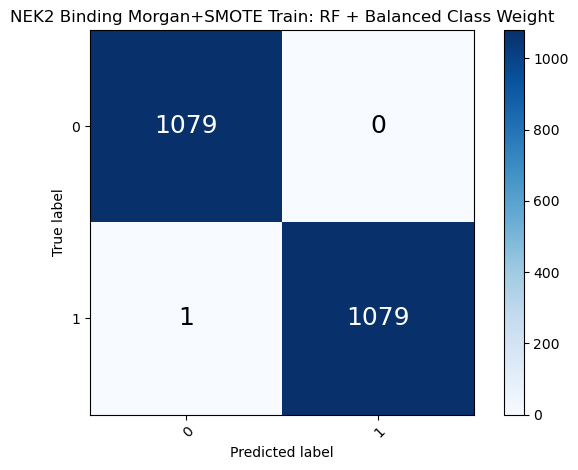

<Figure size 600x400 with 0 Axes>

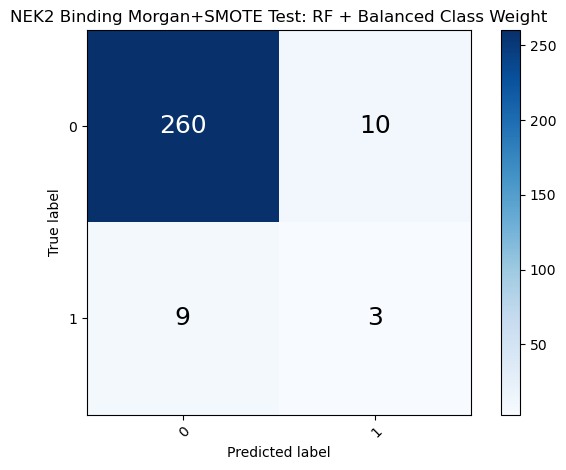

In [8]:
brf_model_BCW = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {})
plot_confusion_matrix(train_y, brf_model_BCW['train_pred'], ['0','1'], title='NEK2 Binding Morgan+SMOTE Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW['test_pred'], ['0','1'], title='NEK2 Binding Morgan+SMOTE Test: RF + Balanced Class Weight')

In [14]:
for param,value in brf_model_BCW['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [9]:
save_file2 = 'atom_nek2bindMorgan2SMOTE_rf_basicBCW_grid.pkl'
# rf_basicBCWbest = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  2)
# save_file2 = 'atom_nek2bindMorgan2SMOTE_rf_basicBCW_grid.pkl'
# with open(save_file2, 'wb') as f:
#     pickle.dump(rf_basicBCWbest['best_model'], f)

TRAIN: accuracy: 0.990, precision: 0.996, recall: 0.983,  specificity: 0.996
TEST: accuracy: 0.957, precision: 0.500, recall: 0.250, specificity: 0.989
bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: entropy
max_depth: 20
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

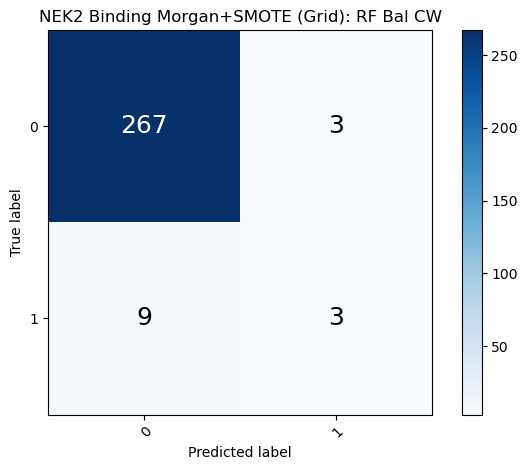

In [10]:
with open('../saved_models/'+save_file2, 'rb') as f: 
    rf_basicBCWbestmodel = pickle.load(f) 

rf_bcw_results = rf_results2(rf_basicBCWbestmodel, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, rf_bcw_results['test_pred'], ['0','1'], title='NEK2 Binding Morgan+SMOTE (Grid): RF Bal CW')
for param,value in rf_basicBCWbestmodel.get_params().items(): 
    print(f'{param}: {value}')


# Balanced Random Forest Classifier

/Users/jayceepang/miniconda3/envs/nek2_final/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/nek2_final/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 0.999, specificity: 1.000
TEST: accuracy: 0.940, precision: 0.273, recall: 0.250, specificity: 0.970


<Figure size 600x400 with 0 Axes>

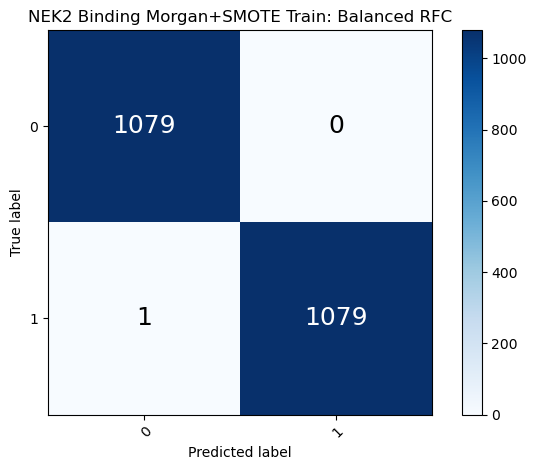

<Figure size 600x400 with 0 Axes>

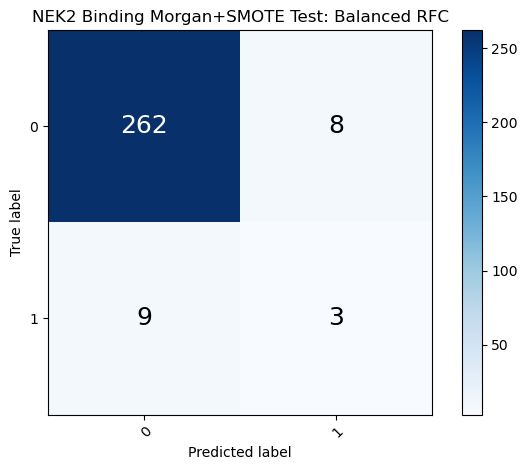

In [11]:
brf_model = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {})
plot_confusion_matrix(train_y, brf_model['train_pred'], ['0','1'], title='NEK2 Binding Morgan+SMOTE Train: Balanced RFC')
plot_confusion_matrix(test_y, brf_model['test_pred'], ['0','1'], title='NEK2 Binding Morgan+SMOTE Test: Balanced RFC')

In [24]:
for param,value in brf_model['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False


In [13]:
save_file3 = 'atom_nek2bindMorgan2SMOTE_BRFC_grid.pkl'
# brfc_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {}, param_grid, 2)
# with open(save_file3, 'wb') as f:
#     pickle.dump(brfc_best['best_model'], f)

TRAIN: accuracy: 0.998, precision: 0.997, recall: 0.999,  specificity: 0.997
TEST: accuracy: 0.957, precision: 0.500, recall: 0.417, specificity: 0.981
bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: entropy
max_depth: 200
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

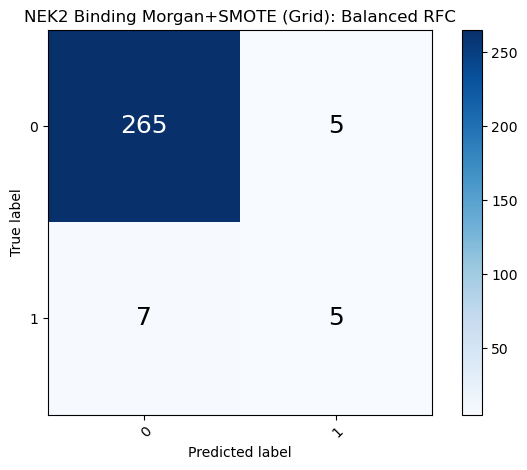

In [14]:
with open('../saved_models/'+save_file3, 'rb') as f: 
    brfc_best = pickle.load(f) 
brfc_results = rf_results2(brfc_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, brfc_results['test_pred'], ['0','1'], title='NEK2 Binding Morgan+SMOTE (Grid): Balanced RFC')
for param,value in brfc_best.get_params().items(): 
    print(f'{param}: {value}')

# Try BRFC with balanced class weight & bootstrap

/Users/jayceepang/miniconda3/envs/nek2_final/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/nek2_final/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 0.999, recall: 1.000, specificity: 0.999
TEST: accuracy: 0.961, precision: 0.571, recall: 0.333, specificity: 0.989


<Figure size 600x400 with 0 Axes>

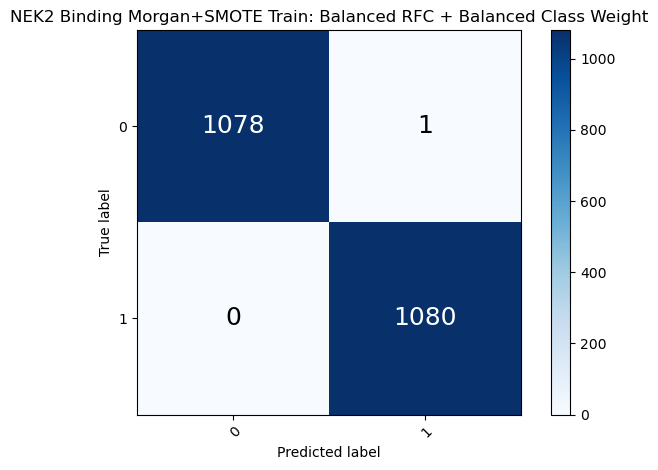

<Figure size 600x400 with 0 Axes>

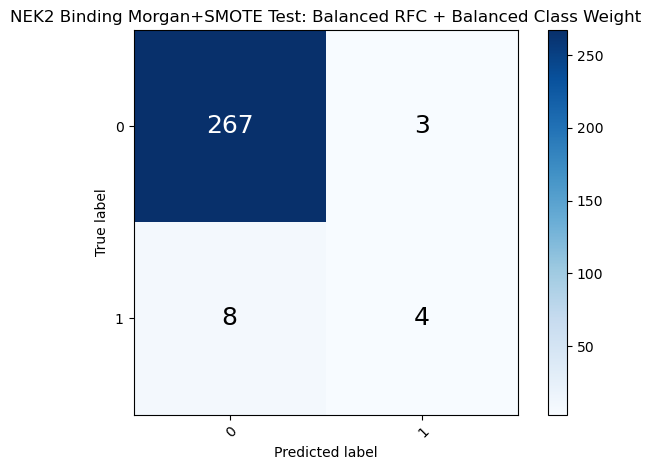

In [15]:
brf_modelCWB = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True})
plot_confusion_matrix(train_y, brf_modelCWB['train_pred'], ['0','1'], title='NEK2 Binding Morgan+SMOTE Train: Balanced RFC + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB['test_pred'], ['0','1'], title='NEK2 Binding Morgan+SMOTE Test: Balanced RFC + Balanced Class Weight')

In [16]:
for param,value in brf_modelCWB['model'].get_params().items(): 
    print(f'{param}: {value}')
    

bootstrap: True
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False


In [17]:
save_file4 = 'atom_nek2bindMorgan2SMOTE_BRFC_BCW_grid.pkl'
# brfc_BCW_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True}, param_grid, 2)
# with open(save_file4, 'wb') as f:
#     pickle.dump(brfc_BCW_best['best_model'], f)


# with open(save_file4, 'rb') as f: 
#     brfc_BCW_best = pickle.load(f) 

TRAIN: accuracy: 0.998, precision: 0.997, recall: 0.999,  specificity: 0.997
TEST: accuracy: 0.957, precision: 0.500, recall: 0.417, specificity: 0.981
bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: entropy
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 4
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 1050
n_jobs: None
oob_score: False
random_state: None
replacement: warn
sampling_strategy: warn
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

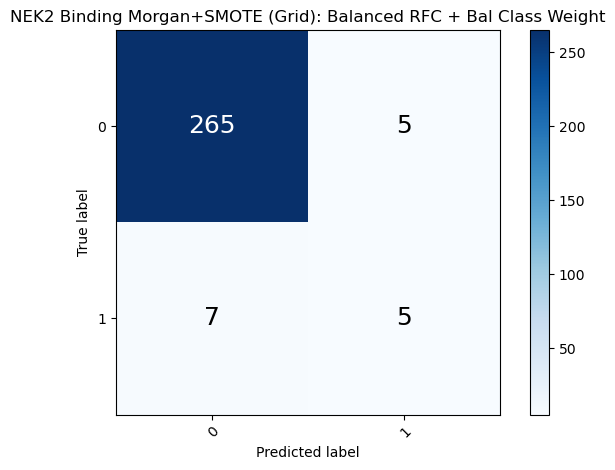

In [18]:
with open('../saved_models/'+save_file4, 'rb') as f: 
    brfc_bcw_best = pickle.load(f) 
brfc_bcw_best_results = rf_results2(brfc_bcw_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, brfc_bcw_best_results['test_pred'], ['0','1'], title='NEK2 Binding Morgan+SMOTE (Grid): Balanced RFC + Bal Class Weight')
for param,value in brfc_bcw_best.get_params().items(): 
    print(f'{param}: {value}')

In [23]:
# max depth was default 1-- 
# temp_nek2bind_MOE_original = {'default_RF':rf_basic100est['model'], 'rf_bcw':brf_model_BCW['model'],
#                               'BRFC': brf_model['model'], 'BRFC_bcw':brf_modelCWB['model']}

# with open('temp_nek2bind_originalmodels.pkl', 'wb') as f:
#     pickle.dump(temp_nek2bind_MOE_original, f)
# with open('temp_nek2bind_originalmodels.pkl', 'rb') as f: 
#     temp_dict = pickle.load(f)

In [48]:
nek2bind_scaledmodels = {'default_RF':rf_basic_best, 'rf_bcw':rf_basicBCWbestmodel,
                              'BRFC': brfc_best, 'BRFC_bcw':brfc_bcw_best}

# with open('nek2bind_Morgan2SMOTEmodels.pkl', 'wb') as f:
#     pickle.dump(nek2bind_scaledmodels, f)


In [50]:
grid_models = [rf_basic_best, rf_basicBCWbestmodel,brfc_best,brfc_bcw_best]
model_dictionaries = []
for i, model in enumerate(grid_models): 
    train_results = save_rf_results(model, train_x, train_y)
    test_results  = save_rf_results(model, test_x, test_y) 
    model_dict = {'model':model, 'train_results':train_results, 'test_results':test_results}
    model_dictionaries.append(model_dict) 

# with open('nek2_bind_Morgan2SMOTE_results.pkl', 'wb') as f:
#     pickle.dump(model_dictionaries, f)

In [51]:
tree_probs = np.array([tree.predict_proba(train_x)[:,1] for tree in brfc_bcw_best.estimators_])
tree_probs

array([[0. , 0. , 0. , ..., 1. , 1. , 1. ],
       [0. , 0. , 0. , ..., 1. , 1. , 1. ],
       [0. , 0. , 0. , ..., 1. , 1. , 1. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0.5, 1. ],
       [0. , 0. , 0. , ..., 1. , 1. , 1. ],
       [0. , 0. , 0. , ..., 1. , 1. , 1. ]])

In [52]:
train_prob0 = brfc_bcw_best.predict_proba(train_x)[:,0]
train_prob1 = brfc_bcw_best.predict_proba(train_x)[:,1]
train_prob0std = brfc_bcw_best.predict_proba(train_x)[:,0].std(axis=0)
train_prob1std = brfc_bcw_best.predict_proba(train_x)[:,1].std(axis=0)
train_prob1std

test_prob0 = brfc_bcw_best.predict_proba(test_x)[:,0]
test_prob1 = brfc_bcw_best.predict_proba(test_x)[:,1]
test_prob0std = brfc_bcw_best.predict_proba(test_x)[:,0].std(axis=0)
test_prob1std = brfc_bcw_best.predict_proba(test_x)[:,1].std(axis=0)
test_prob1std

0.15768584924229853

In [53]:
def plot_prob(prob_class0, prob_class1, title, bind_inhib):
    """Histogram of probabilities for each class
    prob_class0: probabilities for class 0.
    prob_class1: probabilities for class 1.
    """
    fig_width = 10
    fig_height = 8
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    bins = np.linspace(0, 1, 50) 
    ax.hist(prob_class0, bins, alpha=0.5, label=f'(No {bind_inhib})')
    ax.hist(prob_class1, bins, alpha=0.5, label=f'{bind_inhib}')

    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')
    plt.title(title, fontsize=24)
    plt.legend(loc='upper center', fontsize=18)
    plt.grid(True)
    plt.title(title)
    plt.show();

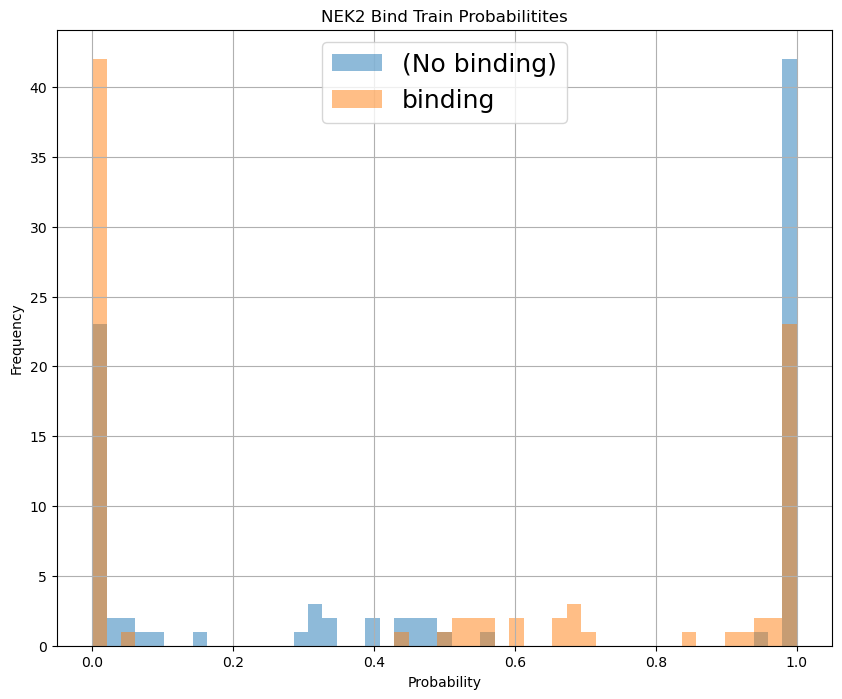

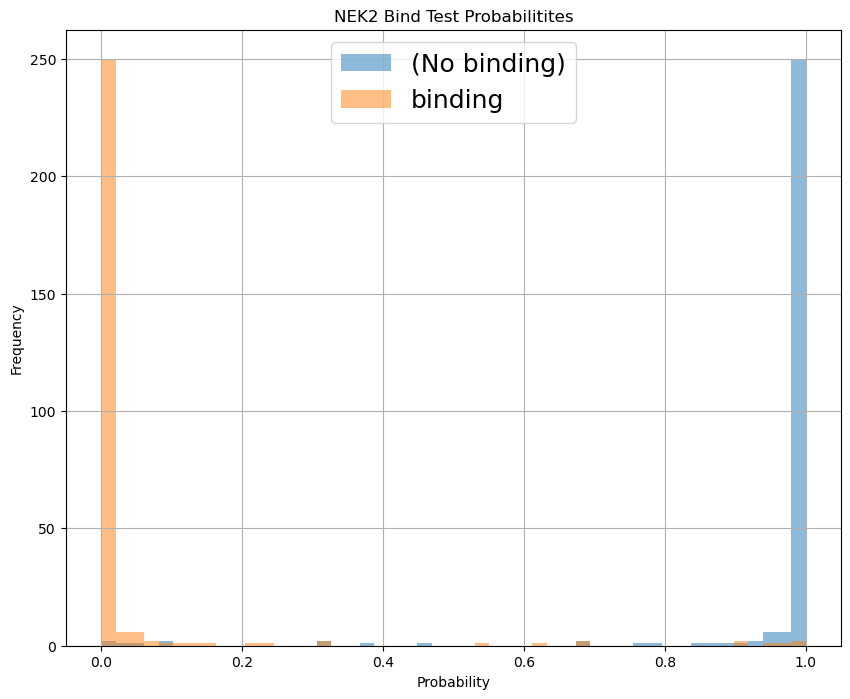

In [54]:
plot_prob(train_prob0, train_prob1, 'NEK2 Bind Train Probabilitites', 'binding')
plot_prob(test_prob0, test_prob1, 'NEK2 Bind Test Probabilitites', 'binding')

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


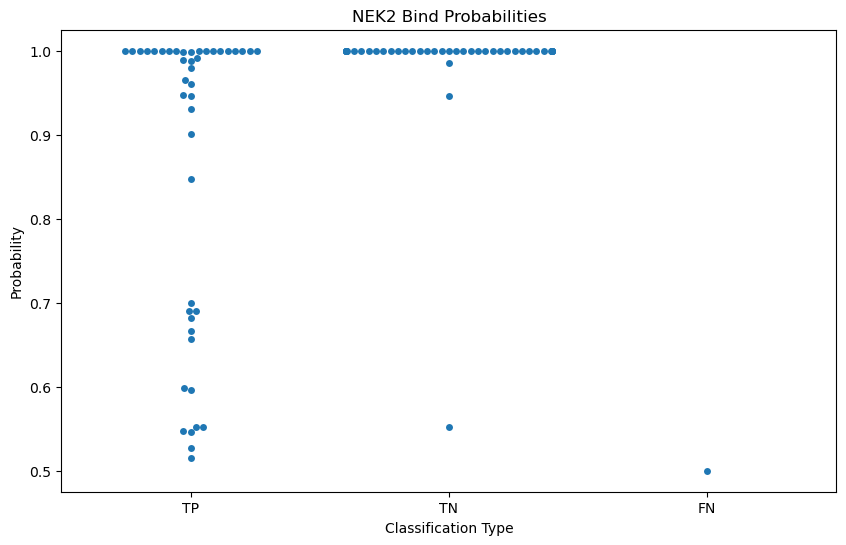

In [55]:
swarm_prob(brfc_bcw_best, train_x, train_y, 'NEK2 Bind Probabilities')

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 81.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 83.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


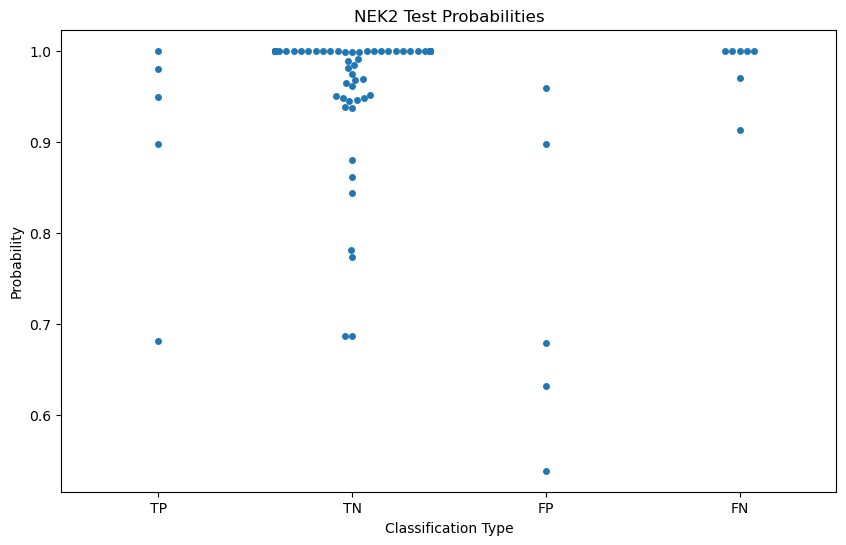

In [56]:
swarm_prob(brfc_bcw_best, test_x, test_y, 'NEK2 Test Probabilities')